<a href="https://colab.research.google.com/github/shuvamg007/learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Dense, Normalization, Conv2DTranspose, LeakyReLU, BatchNormalization, Input
from keras.models import Sequential
import keras
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

tf.random.set_seed(42)

In [ ]:
devices = tf.config.list_physical_devices('GPU')
device_name = None

for device in devices:
    print(f'Found GPU at: {device.name}')
    tf.config.experimental.set_memory_growth(device, enable=True)

In [ ]:
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
iter = ds.as_numpy_iterator()

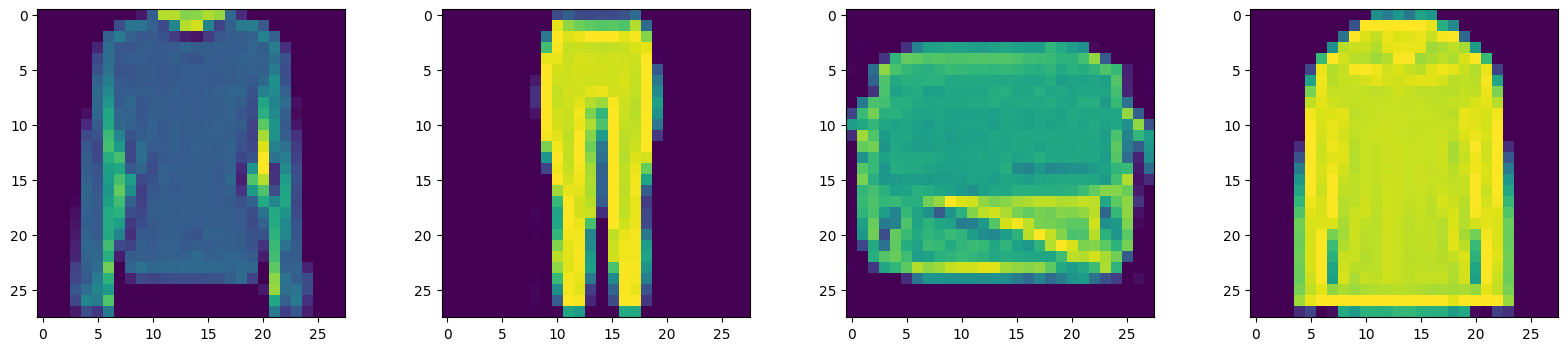

In [ ]:
 # visualize
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i in range(4):
    ax[i].imshow(np.squeeze(iter.next()['image']))

plt.show()
None

In [ ]:
# scale input
def scale(data):
    return data['image'] / 255

In [ ]:
# pre-processing data
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale)
ds = ds.cache()
ds = ds.shuffle(20000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [ ]:
# define network
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dense, Dropout, UpSampling2D, Flatten, Reshape
from keras.models import Sequential 

In [ ]:
def generator():
    model = Sequential()

    # block 1 (with random values)
    model.add(Dense(7 * 7 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # upsampling block 1
    model.add(UpSampling2D()) # by default 2x2
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # upsampling block 2
    model.add(UpSampling2D()) # by default 2x2
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # conv block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # conv block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='tanh'))

    return model

In [ ]:
g = generator()

In [ ]:
g.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 162ms/step


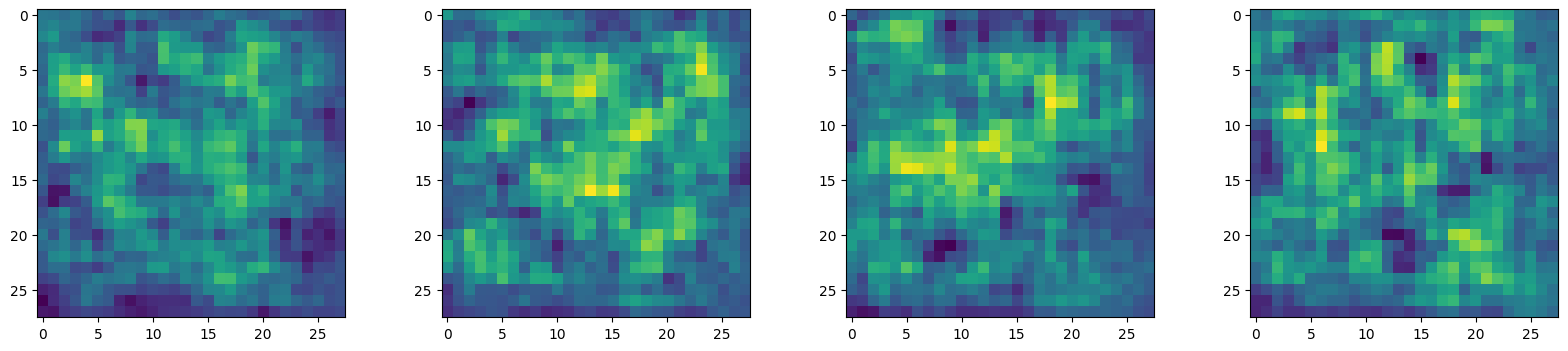

In [ ]:
imgs = g.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(img))

plt.show()
None

In [ ]:
def discriminator():
    model = Sequential()

    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
d = discriminator()

In [ ]:
d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
d.predict(np.expand_dims(imgs[0], 0))

1/1 [==============================] - 0s 82ms/step


array([[0.5013865]], dtype=float32)

In [ ]:
# GAN training loop
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
g_optim = Adam(0.0001)
d_optim = Adam(0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
from keras.models import Model

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, g_optim, d_optim, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        input = batch
        fake = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(input, training=True)
            yhat_fake = self.discriminator(fake, training=True)

            yhat_fakereal = tf.concat([yhat_real, yhat_fake], axis=0)
            y_fakereal = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))

            y_fakereal += tf.concat([noise_real, noise_fake], axis=0)

            total_dloss = self.d_loss(y_fakereal, yhat_fakereal)

        d_grad = d_tape.gradient(total_dloss, self.discriminator.trainable_variables)
        self.d_optim.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            fakes = self.generator(tf.random.normal((128, 128, 1)), training=True)
            y_hat = self.discriminator(fakes, training=False)

            total_gloss = self.g_loss(tf.zeros_like(y_hat), y_hat)

        g_grad = g_tape.gradient(total_gloss, self.generator.trainable_variables)
        self.g_optim.apply_gradients(zip(g_grad, self.generator.trainable_variables))

        return {'g_loss': total_gloss, 'd_loss': total_dloss}


In [ ]:
fashion_gan = FashionGAN(g, d)
fashion_gan.compile(g_optim, d_optim, g_loss, d_loss)

In [ ]:
hist = fashion_gan.fit(ds, epochs=20)

Epoch 1/20
 85/469 [====>.........................] - ETA: 2:08:18 - g_loss: 0.8185 - d_loss: 0.6812